In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F

what we can quantize ? 
1- the wieghts
2- the activation 

after quantization we get : 
- samller models  
- speed gain 
- faster operation 

quantization after the training called POST-TRAINING QUANTIZATION 


## linear quantization is a popluar method of quantization 

in linear quantization we map high presision value to lower
like fp32 to int 8 

Formula : 

r = s(q - z)

where : 
s : scale (as the original tensor)
z : zero point (the quantized tensor)

getting q : 

form the original formaula above 

r/s = q - z 

q = r/s + z 

q = round(r/s + z)
q = int (round(r/s + z))



In [4]:
def linear_Q(
        tensor,
        scale,
        zero,
        dtype = torch.int8
):
    
    scaled_shifted_tensor = tensor / scale + zero 
    rounded = torch.round(scaled_shifted_tensor)

    q_min = torch.iinfo(dtype).min 
    q_max = torch.iinfo(dtype).max 

    q_tensor = rounded.clamp(q_min, q_max).to(dtype)

    return q_tensor

In [5]:
test_tensor = torch.tensor(
    [[191.5 , -13.5, 728.6],
     [92.14, 295.5, -184],
     [0 , 684.6 , 245.5]
    ]
)



In [6]:
scale = 3.5 
zero = -70 

quantized_tensor = linear_Q(test_tensor,scale,zero)

print(quantized_tensor)

tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)


In [7]:
dequant_tensor = scale * (quantized_tensor.float() - zero)
dequant_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

In [8]:
dequant_tensor = scale * (quantized_tensor- zero)
dequant_tensor


tensor([[ 192.5000,  -14.0000, -206.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000, -210.0000,  245.0000]])

In [9]:
def linear_DQ(quantized_tensor, scale, zero):
    return scale * (quantized_tensor- zero)

In [10]:
# ploting helper function for quantization error 


linear quantization mao [rmin , rmax] to the [qmin , qmax]

rmin = s(qmin - z)
rmax = s(qmax - z)

so for s : 

s = (rmax -rmin) / (qmax -qmin)

and for z: 

z = int(round(qmin - rmin / s) --> same data type as quantized tensor


for the prevuos example find s and z ? 


handling the edge cases for z 
what happen if tyhe zero value is out of range 

if z > qmax >> z = qmax 
if z < qmin >> z = qmin 

In [11]:
def get_scale_and_zero_values(
        r_tensor,
        dtype = torch.int8
):
    q_max , q_min = torch.iinfo(dtype).max , torch.iinfo(dtype).min 
    r_min , r_max  = r_tensor.min().item() , r_tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min) 
    z = q_min - (r_min/scale)

    if q_min <=z <= q_max :
        z = int(round(z))
    elif z < q_min : 
        z = q_min 
    elif z < q_max : 
        z = q_max

    return scale , z 
    
 

In [12]:
new_scale , new_zero = get_scale_and_zero_values(test_tensor, torch.int8)

print(new_scale)
print(new_zero)

3.578823433670343
-77


In [13]:
quantized_tensor = linear_Q(test_tensor, new_scale, new_zero)
dequant_tensor = linear_DQ (quantized_tensor, new_scale, new_zero) 

In [14]:
print(quantized_tensor)
print(dequant_tensor)

tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)
tensor([[ 193.2565,  -14.3153, -186.0988],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000, -232.6235,  246.9388]])


In [15]:
# test the error again

In [16]:
# make a general linear quantazation funcion:
def linear_quantizer(tensor,dtype = torch.int8):
    scale , zero_point = get_scale_and_zero_values(tensor, dtype=dtype)
    quantized_tensor = linear_Q(tensor, scale , zero_point, dtype=dtype)
    return quantized_tensor , scale , zero_point


In [17]:
r_tensor = torch.randn((4,4))
r_tensor

tensor([[-0.0478,  1.7570, -0.7924, -1.0906],
        [-0.4930,  0.0235, -0.6162,  0.5439],
        [-0.5460,  0.5273,  0.8849, -0.6643],
        [-0.2852, -1.2923,  0.5774, -0.5834]])

In [18]:
quantized_tensor , scale , zero = linear_quantizer(r_tensor)

In [19]:
quantized_tensor

tensor([[ -24,  127,  -86, -111],
        [ -61,  -18,  -72,   25],
        [ -66,   24,   54,  -76],
        [ -44, -128,   28,  -69]], dtype=torch.int8)

In [20]:
zero 

-20

In [21]:
scale

0.011958020808649997

In [22]:
##SEMMETRICS VS ASYMMERTICS MODE : 

def symmetric_q_scale(tensor , dtype = torch.int8):
    r_max = tensor.abs().max().item() 
    q_max = torch.iinfo(dtype).max 
    return r_max / q_max 


In [23]:
test_tensor = torch.randn((4,4))
test_tensor

tensor([[ 0.5755, -0.9131,  1.6683, -0.3982],
        [ 1.0982,  0.8709, -0.1981,  0.4716],
        [ 0.6617, -0.8226, -0.4381, -0.0852],
        [ 0.5221, -1.0901,  2.5888,  1.7138]])

In [24]:
print(symmetric_q_scale(test_tensor))

0.020384512548371564


In [25]:
def linear_q_sym(tensor , dtype = torch.int8):
    scale = symmetric_q_scale(tensor)
    quantized_tensor = linear_Q(tensor, scale,zero=0,dtype=dtype)
    return quantized_tensor , scale


In [26]:
quantized_tensor , scale = linear_q_sym(test_tensor)
quantized_tensor

tensor([[ 28, -45,  82, -20],
        [ 54,  43, -10,  23],
        [ 32, -40, -21,  -4],
        [ 26, -53, 127,  84]], dtype=torch.int8)

In [27]:
## def quantization_error():
## the trade off and the usew cases of the two types of quantization 

- when using asymm qi=uantization the q range is fully utilized 
- in symm if the float points is bias towrd one side  (like relu activation) the quantized range will be also bias toward one side 
- symm is more simplier 
- also more memeory effience since we dont store the zero value (z = 0)

in practice : 
- symm for 8 bit 
- for lower bit like 2 and 4 use asymm 


Type of quantization methos : 
- per tensor quan 
- per channel quan 


In [28]:
## Per Channel Quantization
## we need to store the z and scale for every row (if we decide to use the row) or alonmg the coloums 
## the memory required is low and we use this normally with 8 bit quantization 
import torch

def linear_q_sym_per_channel(tensor,
                             dim,
                             dtype=torch.int8):
    # tensor: Input tensor of shape (N, C, H, W) or any arbitrary shape
    # dim: The dimension along which quantization is performed
    # dtype: Data type for quantization (default: int8)

    output_dim = tensor.shape[dim]  # Size of the selected dimension
    scale = torch.zeros(output_dim)  # Shape: (output_dim,)

    for index in range(output_dim):
        sub_tensor = tensor.select(dim, index)  # Shape: (remaining dimensions after selecting along 'dim')
        scale[index] = symmetric_q_scale(sub_tensor, dtype=dtype)  # Compute scale for the sub-tensor

        scale_shape = [1] * tensor.dim()  # Create shape list with all ones
        scale_shape[dim] = -1  # Set the selected dimension to -1 (broadcasting)
        scale = scale.view(scale_shape)  # Reshape scale tensor to match broadcasting shape

        quantized_tensor = linear_Q(tensor, scale, zero=0, dtype=dtype)  
        # quantized_tensor: Same shape as input tensor

        return quantized_tensor, scale  # quantized_tensor shape: same as tensor, scale shape: broadcasted shape


In [29]:
test_tensor = torch.tensor(
    [[191.5 , -13.5, 728.6],
     [92.14, 295.5, -184],
     [0 , 684.6 , 245.5]
    ]
)

dim = 0

out_dim = test_tensor.shape[dim]
out_dim

3

In [30]:
scale = torch.zeros(out_dim)
scale

tensor([0., 0., 0.])

In [31]:
for index in range(out_dim):
    sub_tensor = test_tensor.select(dim , index)
    # print(sub_tensor)
    scale[index] = symmetric_q_scale(sub_tensor)
    # print(scale[index])

scale 


tensor([5.7370, 2.3268, 5.3906])

In [32]:
scale_shape = [1] * test_tensor.dim()
scale_shape

[1, 1]

In [33]:
scale_shape[dim] = -1
scale_shape

[-1, 1]

In [34]:
scale = scale.view(scale_shape)
scale 

tensor([[5.7370],
        [2.3268],
        [5.3906]])

In [35]:
quantized_tensor = linear_Q(test_tensor, scale, zero=0) 
quantized_tensor

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)

In [36]:
quantized_tensor_0 , scale_0 = linear_q_sym_per_channel(test_tensor, dim=0)
quantized_tensor_0

tensor([[  33,   -2,  127],
        [ 127,  127, -128],
        [   0,  127,  127]], dtype=torch.int8)

In [37]:
quantized_tensor_1, scale_1 = linear_q_sym_per_channel(test_tensor, dim=1)
quantized_tensor_1

tensor([[ 127, -128,  127],
        [  61,  127, -128],
        [   0,  127,  127]], dtype=torch.int8)

In [38]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch


def quantization_error(tensor, dequantized_tensor):
    return (dequantized_tensor - tensor).abs().square().mean()


def linear_q_with_scale_and_zero_point(
    r_tensor, scale, zero_point, dtype=torch.int8):
    """
    Performs simple linear quantization given
    the scale and zero-point.
    """

    # scale tensor and add the zero point
    scaled_and_shifted_tensor = r_tensor / scale + zero_point

    # round the tensor 
    rounded_tensor = torch.round(scaled_and_shifted_tensor)

    # we need to clamp to the min/max value of the specified dtype
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)
    return q_tensor


def linear_dequantization(quantized_tensor, scale, zero_point):
    """
    Linear de-quantization
    """
    dequantized_tensor = scale * (quantized_tensor.float() - zero_point)

    return dequantized_tensor

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()

def get_q_scale_and_zero_point(r_tensor, dtype=torch.int8):
    """
    Get quantization parameters (scale, zero point) 
    for a floating point tensor
    """
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = r_tensor.min().item(), r_tensor.max().item()

    scale = (r_max-r_min)/(q_max-q_min)

    zero_point = q_min-(r_min/scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min or zero_point > q_max:
        zero_point = q_min
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    return scale, zero_point

def linear_quantization(r_tensor, n_bits, dtype=torch.int8):
    """
    linear quantization
    """

    scale, zero_point = get_q_scale_and_zero_point(r_tensor)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=zero_point, dtype=dtype)

    return quantized_tensor, scale, zero_point


############# From the previous lesson(s) of "Linear Quantization II"
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    
    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)

    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=0, dtype=dtype)
   
    return quantized_tensor, scale


def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max

    # return the scale
    return r_max/q_max
###################################

In [39]:
## compare the error for the two 

In [40]:
def linear_q_symmetric_per_group(tensor, group_size,
                                 dtype=torch.int8):
    
    t_shape = tensor.shape
    assert t_shape[1] % group_size == 0
    assert tensor.dim() == 2
    
    tensor = tensor.view(-1, group_size)
    
    quantized_tensor, scale = linear_q_symmetric_per_channel(
                                tensor, dim=0, dtype=dtype)
    
    quantized_tensor = quantized_tensor.view(t_shape)
    
    return quantized_tensor, scale

In [41]:
def linear_dequantization_per_group(quantized_tensor, scale, 
                                    group_size):
    
    q_shape = quantized_tensor.shape
    quantized_tensor = quantized_tensor.view(-1, group_size)
    
    dequantized_tensor = linear_dequantization(quantized_tensor, 
                                               scale, 0)
    
    dequantized_tensor = dequantized_tensor.view(q_shape)
    
    return dequantized_tensor

In [42]:
random_tensor =torch.rand((6,6))
group_size = 3 
random_tensor

tensor([[0.9585, 0.3314, 0.5001, 0.3210, 0.7089, 0.4766],
        [0.9081, 0.2450, 0.5245, 0.2804, 0.9393, 0.9100],
        [0.0133, 0.1854, 0.5191, 0.5546, 0.5556, 0.5216],
        [0.1969, 0.8969, 0.6583, 0.8039, 0.6270, 0.2543],
        [0.8023, 0.1053, 0.9845, 0.9394, 0.3305, 0.9571],
        [0.8021, 0.1984, 0.8703, 0.3725, 0.7622, 0.9905]])

In [43]:
quantized_tensor , scale = linear_q_symmetric_per_group(random_tensor, group_size)
dequant_tensor  = linear_dequantization_per_group(quantized_tensor, scale, group_size)

In [44]:
quantized_tensor 

tensor([[127,  44,  66,  57, 127,  85],
        [127,  34,  73,  38, 127, 123],
        [  3,  45, 127, 127, 127, 119],
        [ 28, 127,  93, 127,  99,  40],
        [103,  14, 127, 125,  44, 127],
        [117,  29, 127,  48,  98, 127]], dtype=torch.int8)

In [45]:
dequant_tensor

tensor([[0.9585, 0.3321, 0.4981, 0.3182, 0.7089, 0.4745],
        [0.9081, 0.2431, 0.5220, 0.2810, 0.9393, 0.9097],
        [0.0123, 0.1839, 0.5191, 0.5556, 0.5556, 0.5206],
        [0.1977, 0.8969, 0.6568, 0.8039, 0.6267, 0.2532],
        [0.7984, 0.1085, 0.9845, 0.9420, 0.3316, 0.9571],
        [0.8018, 0.1987, 0.8703, 0.3743, 0.7643, 0.9905]])

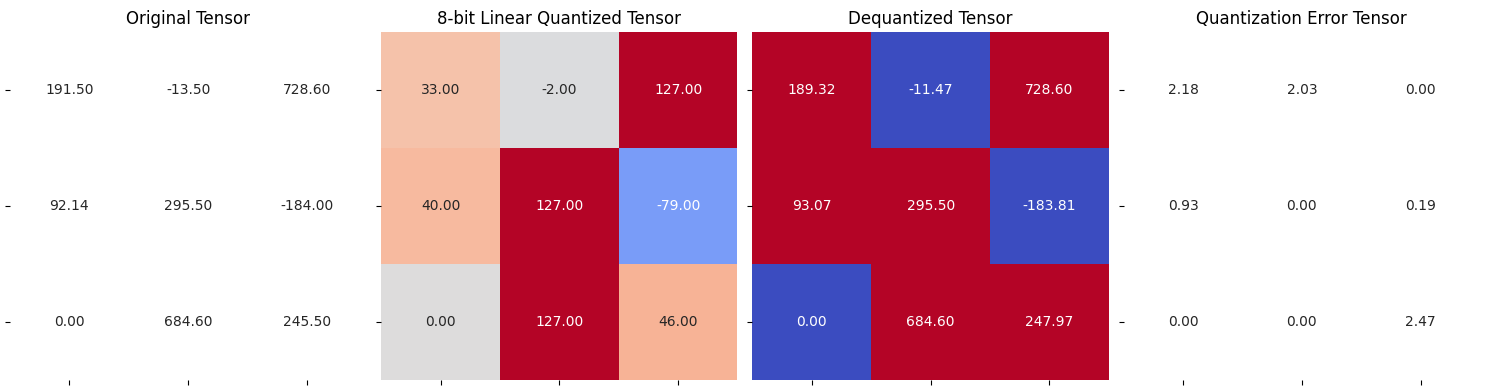

In [46]:
quantized_tensor, scale = linear_q_symmetric_per_group(
    test_tensor, group_size=group_size)

dequantized_tensor = linear_dequantization_per_group(
    quantized_tensor, scale, group_size=group_size)

plot_quantization_errors(
    test_tensor, quantized_tensor, dequantized_tensor)

In [47]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 1.7589133977890015


In [66]:
## coding a custom 8bit quantizer :
## this quantizer is model agnostic meaning it can be used for any model langauge , vision , or multimodal
## we will use the linear quantizer scheme to quantize the weights of the model 

## the steps for the project : 
## creating a W8A16LinearLayer class to store 8 bits weights and scales 
## replacing the torch linear layer with the W8A16LinearLayer class 
## creating a function to quantize the weights of the model 
## testing the implemetaion 

## W8A16LinearLayer class : 
## * w8_16_forward function -> weight , input , scale , bias (optional)


## some randon tensor for testing

random_int8 = torch.randint(-128, 127, (32, 16), dtype=torch.int8)
random_hs = torch.randn((1, 16), dtype=torch.bfloat16)
scales = torch.randn((1, 32), dtype=torch.bfloat16)
bias = torch.randn((1, 32), dtype=torch.bfloat16)

In [ ]:
## whats is the diffrent between nn.linear and F.linear ? 
## look at this example :
# Using nn.Linear (recommended)

linear_layer = nn.Linear(in_features=10, out_features=5)  # Creates and registers parameters
input_tensor = torch.randn(20, 10) #batch size 20, input features 10
output = linear_layer(input_tensor) #batch size 20, output features 5

print(list(linear_layer.parameters())) #prints the weight and bias of the linear layer

# Using F.linear
w = torch.randn(5, 10)  # You must create the weight tensor
b = torch.randn(5)      # And the bias tensor (optional)
output_f = F.linear(input_tensor, w, b)

print(w) #prints the weight tensor
print(b)   #prints the bias tensor

[Parameter containing:
tensor([[ 0.0452, -0.2850,  0.2928, -0.1139, -0.0410,  0.2362, -0.2939, -0.2566,
          0.1713,  0.2796],
        [-0.1370, -0.1102,  0.1843, -0.1955,  0.2612, -0.0980, -0.0192, -0.1338,
         -0.2708, -0.1222],
        [ 0.2873,  0.1881,  0.2249, -0.2059, -0.1164,  0.0050, -0.0307, -0.2393,
         -0.2448, -0.2674],
        [-0.1245,  0.2401, -0.0790,  0.2627,  0.0135, -0.1685, -0.1371, -0.3098,
          0.0167, -0.2767],
        [ 0.2001,  0.1852, -0.1193,  0.2139, -0.3126,  0.1457, -0.2942,  0.0532,
          0.0291, -0.0789]], requires_grad=True), Parameter containing:
tensor([ 0.2001,  0.1408, -0.0970,  0.1433,  0.1441], requires_grad=True)]
tensor([[ 1.7564e+00,  7.1541e-01,  3.5405e-01, -1.6998e+00,  2.9643e+00,
         -5.1511e-01, -2.4580e-01, -8.9450e-01, -1.0912e+00,  3.9150e-01],
        [-1.4919e+00, -3.1828e-01,  1.3454e+00,  5.6489e-01, -3.7040e-01,
          5.8199e-01, -2.3028e-02,  2.7163e-01,  2.3809e+00, -1.3139e-03],
        [-2.678

In [61]:
# Using nn.Linear (recommended) and cASTING the weights to bfloat16 (same as the hiden states)
F.linear(random_hs, random_int8.to(random_hs.dtype))

tensor([[ 196.0000,  264.0000,  264.0000,  214.0000,  135.0000,  -14.0625,
          159.0000, -114.5000, -280.0000,  156.0000, -115.0000,  328.0000,
           77.0000,  394.0000,  147.0000, -126.0000,   11.3125, -286.0000,
         -217.0000,  149.0000, -147.0000,  314.0000,  137.0000,   -7.6250,
          264.0000,   75.0000,  109.5000,  251.0000,  180.0000, -536.0000,
           91.5000,  -74.5000]], dtype=torch.bfloat16)

In [62]:
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales 

tensor([[  -95.0000,   111.0000,   253.0000,   -50.7500,  -220.0000,   -15.6875,
           137.0000,   181.0000,    82.5000,  -222.0000,   199.0000,  -102.5000,
           -44.7500, -1096.0000,   104.0000,   179.0000,   -13.2500,  -181.0000,
            32.5000,   -50.0000,   185.0000,    40.7500,    51.7500,     3.9844,
          -194.0000,    57.7500,    73.5000,   -64.5000,   143.0000,   356.0000,
           174.0000,    85.0000]], dtype=torch.bfloat16)

In [68]:
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales + bias

tensor([[-3.9062e-03, -4.6400e+02,  3.0800e+02, -3.6600e+02, -6.0400e+02,
         -6.9500e+01, -3.1200e+02, -5.5250e+01, -6.6800e+02, -1.4800e+02,
         -5.5200e+02, -4.2812e+00, -2.6125e+01,  7.3600e+02, -4.1250e+01,
          3.7600e+02, -1.7125e+01, -1.3500e+02,  2.0700e+02, -9.8500e+01,
          2.1625e+01,  3.2600e+02, -1.0480e+03,  1.6250e+01, -1.9000e+01,
          2.9500e+01, -8.6400e+02,  8.0500e+01, -9.7200e+02, -2.3400e+02,
          3.7200e+02, -6.5200e+02]], dtype=torch.bfloat16)

In [ ]:
## notice that its imporant for the shape of the sacle and bias to be the same as the output of the linear layer so ypou can broadcast the addition correctly

## lets combine this into function:
def w8_16_forward(weight, input, scale, bias=None):
    casted_weight = weight.to(input.dtype) 
    output = F.linear(input, casted_weight) * scale
    if bias is not None:
        output += bias
    return output


In [73]:
print("with bias:")
w8_16_forward(random_int8, random_hs, scales, bias)


with bias:


tensor([[-3.9062e-03, -4.6400e+02,  3.0800e+02, -3.6600e+02, -6.0400e+02,
         -6.9500e+01, -3.1200e+02, -5.5250e+01, -6.6800e+02, -1.4800e+02,
         -5.5200e+02, -4.2812e+00, -2.6125e+01,  7.3600e+02, -4.1250e+01,
          3.7600e+02, -1.7125e+01, -1.3500e+02,  2.0700e+02, -9.8500e+01,
          2.1625e+01,  3.2600e+02, -1.0480e+03,  1.6250e+01, -1.9000e+01,
          2.9500e+01, -8.6400e+02,  8.0500e+01, -9.7200e+02, -2.3400e+02,
          3.7200e+02, -6.5200e+02]], dtype=torch.bfloat16)

In [74]:

print("without bias:")
w8_16_forward(random_int8, random_hs, scales)

without bias:


tensor([[-3.0078e-01, -4.6400e+02,  3.0800e+02, -3.6600e+02, -6.0400e+02,
         -6.9000e+01, -3.1200e+02, -5.3750e+01, -6.6800e+02, -1.4900e+02,
         -5.5200e+02, -3.7344e+00, -2.5500e+01,  7.3600e+02, -4.0750e+01,
          3.7800e+02, -1.6625e+01, -1.3500e+02,  2.0600e+02, -9.7500e+01,
          2.1750e+01,  3.2400e+02, -1.0480e+03,  1.6250e+01, -1.8750e+01,
          2.9500e+01, -8.6400e+02,  8.0000e+01, -9.7200e+02, -2.3300e+02,
          3.7200e+02, -6.5200e+02]], dtype=torch.bfloat16)

In [ ]:
## next lets consider the process 

class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        super().__init__()

        ## this method is wrong but it shows the idea
        self.int8_weight = nn.Parameter(torch.randint(-128, 127, (out_features, in_features)).to(dtype=torch.int8))
        

    


        

lets try ti init the class and see what will happen 

In [79]:
layer = W8A16LinearLayer(16, 32)

RuntimeError: Only Tensors of floating point and complex dtype can require gradients

As you see you get A RuntimeError , that because pytorch nn.Parameter automatically assign the tensor to the computaional graph and try to get the gradient , but there is no gradient for int8 in oytorch yet! 

so what we can do ? 

see the following 

In [80]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        super().__init__()

        self.register_buffer("int8_weight",
                            torch.randint(-128, 127, (out_features, in_features)).to(dtype=torch.int8))

In [81]:
layer = W8A16LinearLayer(16, 32)

No error ! , the method register_buffer just save a buffer with no gradient

lets continue : 

In [88]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        super().__init__()

        self.register_buffer("int8_weight",
                            torch.randint(-128, 127, (out_features, in_features), dtype=torch.int8))
        
        self.register_buffer("scale", torch.randn((out_features)
                             , dtype=dtype))
        
        if bias:
            self.register_buffer("bias", torch.zeros((1, out_features)
                                 , dtype=dtype))
        else:
            self.bias = None


In [ ]:
dummy_instance = W8A16LinearLayer(16, 32)
print(dummy_instance.int8_weight.shape)
print( dummy_instance.scale.shape)

torch.Size([32, 16])
torch.Size([32])


All good now we need the forward pass , which we alredy made:

In [96]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        super().__init__()

        self.register_buffer("int8_weight",
                            torch.randint(-128, 127, (out_features, in_features), dtype=torch.int8))
        
        self.register_buffer("scale", torch.randn((out_features)
                             , dtype=dtype))
        
        if bias:
            self.register_buffer("bias", torch.zeros((1, out_features)
                                 , dtype=dtype))
        else:
            self.bias = None

    def forward(self, x):
        return w8_16_forward(self.int8_weight, x, self.scale, self.bias)



In [97]:
dummy_instance = W8A16LinearLayer(16, 32)
dummy_hs = torch.randn(1, 6, 16)

dummy_instance(dummy_hs).dtype

torch.float32

Now lets make quantize and dequantize method , plus the workflow to quantize a model should as follow : 

we detect all the linear layer on the model 

we loop over thejm and replace the standard nn.linear with the custom made class 

In [114]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        super().__init__()

        self.register_buffer("int8_weight",
                            torch.randint(-128, 127, (out_features, in_features), dtype=torch.int8))
        
        self.register_buffer("scale", torch.randn((out_features)
                             , dtype=dtype))
        
        if bias:
            self.register_buffer("bias", torch.zeros((1, out_features)
                                 , dtype=dtype))
        else:
            self.bias = None

    def quantize(self, weight):
        ## cast to fp32 is recommended for stability
        w_fp32 = weight.clone().to(torch.float32)

        scales = w_fp32.abs().max(dim=-1).values / 127 
        scales = scales.to(weight.dtype) 

        int8_weight = torch.round(w_fp32 / scales.unsqueeze(1)).to(torch.int8)

        self.int8_weight = int8_weight
        self.scale = scales

    def forward(self, input):
        return w8_16_forward(self.int8_weight, input, self.scale, self.bias)
    




In [115]:
dummy_instance = W8A16LinearLayer(4 , 8)

print("before quantization:0", dummy_instance.int8_weight)

before quantization:0 tensor([[ -57,   12,   31,   80],
        [  85,   11,   70,  -29],
        [ -17,    6,   60,  -14],
        [ -40,   -6, -121, -108],
        [ -24,   47,  -68,  -79],
        [ -22,  -10,  119,   -2],
        [ -23,  -67,  -64, -121],
        [-110,  -27,  -18,   31]], dtype=torch.int8)


In [116]:
random_matrix = torch.randn((4, 8), dtype=torch.bfloat16)

dummy_instance.quantize(random_matrix)
print("after quantization:0", dummy_instance.int8_weight)

after quantization:0 tensor([[ -41,  -46,   39,   -4,  -40,  127,  -49,   41],
        [ -10,   22,  127,   18, -102,  -29,   36,  -61],
        [  21,   14,  -50,    1,  -72,  -68,   70, -127],
        [  32,   -6,  -42,   18,  -61,   52,  127,   57]], dtype=torch.int8)


In [117]:
dummy_instance.scale.shape

torch.Size([4])

In [ ]:
dummy_instance.int8_weight.shape

torch.Size([4, 8])

Lets calculate the quantization_error

In [121]:
quantization_error = (random_matrix - dummy_instance.int8_weight * dummy_instance.scale.unsqueeze(1)).abs().mean()
quantization_error


tensor(0.0036, dtype=torch.bfloat16)

Now we ready to make Quantizer (a quantization pipline) which will iterate over the original linear model and replace them with the int8  

In [124]:
def replace_module(module,
                target_class, 
                module_name_to_exclude):
    
    for name, child in module.named_children():

        # if the layer is a linear layer and not in the exclusion list
        if isinstance(child, nn.Linear) and not any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias
            new_module = target_class(
                child.in_features,
                child.out_features,
                child.bias is not None,
                child.weight.dtype
            )
            setattr(module, name, new_module)
            if old_bias is not None:
                getattr(module , name).bias = old_bias 
        
        else : 
            # recursively call the function
            replace_module(child, target_class, module_name_to_exclude)

In [ ]:
# LETS MAKE A DUMMY MODEL (LIKE MINI GPT)
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Embedding(16, 32)
        # with bias
        self.l2 = nn.Linear(32, 64)
        # without bias
        self.l3 = nn.Linear(64, 128, bias=False)
        self.l4 = nn.Linear(128, 256, bias=False)



In [132]:
model_1 = DummyModel()
model_2 = DummyModel()

replace_module(model_1, W8A16LinearLayer, ["l4"])

print("quantized model:",model_1)

print ("unquantized model:",model_2)

quantized model: DummyModel(
  (l1): Embedding(16, 32)
  (l2): W8A16LinearLayer()
  (l3): W8A16LinearLayer()
  (l4): Linear(in_features=128, out_features=256, bias=False)
)
unquantized model: DummyModel(
  (l1): Embedding(16, 32)
  (l2): Linear(in_features=32, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=128, bias=False)
  (l4): Linear(in_features=128, out_features=256, bias=False)
)


In [133]:
def replace_module_and_quantize(module,
                target_class, 
                module_name_to_exclude):
    
    for name, child in module.named_children():

        # if the layer is a linear layer and not in the exclusion list
        if isinstance(child, nn.Linear) and not any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias
            old_weight = child.weight

            new_module = target_class(
                child.in_features,
                child.out_features,
                child.bias is not None,
                child.weight.dtype
            )
            setattr(module, name, new_module)
            getattr(module , name).quantize(old_weight)

            if old_bias is not None:
                getattr(module , name).bias = old_bias 
        
        else : 
            # recursively call the function
            replace_module_and_quantize(child, target_class, module_name_to_exclude)

In [ ]:
model_3 = DummyModel()

replace_module_and_quantize(model_3, W8A16LinearLayer, ["l4"])

print("quantized model:",model_3)


quantized model: DummyModel(
  (l1): Embedding(16, 32)
  (l2): W8A16LinearLayer()
  (l3): W8A16LinearLayer()
  (l4): Linear(in_features=128, out_features=256, bias=False)
)


Lets test the implentaion on a real model 

In [137]:
from UTILS.load_weights import download_and_load_gpt2 , load_weights_into_gpt
from UTILS.model import GPTModel

## Choose the model to use
CHOOSE_MODEL = "gpt2-small (124M)"

## Base configuration settings for the model
BASE_CONFIG = {
    "vocab_size": 50257,     # Size of the vocabulary used by the model
    "context_length": 1024,  # Maximum context length the model can handle
    "drop_rate": 0.0,        # Dropout rate for regularization
    "qkv_bias": True         # Whether to use bias terms in query, key, and value projections
}

## Dictionary containing configurations for different GPT-2 model sizes
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},      # Config for small model
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},    # Config for medium model
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},     # Config for large model
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},       # Config for extra-large model
}

## Update the BASE_CONFIG with parameters specific to the chosen model
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2025-02-21 21:11:40.713174: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [138]:
replace_module_and_quantize(model, W8A16LinearLayer, ["out_head"]) 

print("quantized model:",model)

quantized model: GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): W8A16LinearLayer()
        (W_key): W8A16LinearLayer()
        (W_value): W8A16LinearLayer()
        (out_proj): W8A16LinearLayer()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): W8A16LinearLayer()
          (1): GELU()
          (2): W8A16LinearLayer()
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): W8A16LinearLayer()
        (W_key): W8A16LinearLayer()
        (W_value): W8A16LinearLayer()
        (out_proj): W8A16LinearLayer()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward

In [ ]:
import tiktoken

def top_p_logits(logits, p=0.5):
    probs = F.softmax(logits, dim=-1)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    sorted_probs[cumulative_probs > p] = 0
    filtered_logits = torch.zeros_like(logits).to(logits.device)  # Move to same device
    filtered_logits.scatter_(dim=-1, index=sorted_indices, src=sorted_probs)
    return filtered_logits

def generate(model, prompt, max_new_tokens, context_size, tokenizer, temperature=0.0, top_k=None, top_p=None, eos=None):
    # Detect device
    device = next(model.parameters()).device  # Get model's device

    # Encode and move input to the correct device
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long).unsqueeze(0).to(device)

    idx_gen = idx.clone()  # Start with the prompt indices

    for _ in range(max_new_tokens):
        idx_cond = idx_gen[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)  # Forward pass
            logits = logits[:, -1, :]  # Take the last token's logits
            
            # Apply top-k sampling
            if top_k is not None:
                top_k_values, _ = torch.topk(logits, k=top_k)
                min_value = top_k_values[:, -1].unsqueeze(1)  
                logits = torch.where(logits < min_value, torch.tensor(float('-inf')).to(device), logits)

            # Apply top-p sampling
            if top_p is not None:
                logits = top_p_logits(logits, p=top_p)  

            # Apply temperature
            if temperature > 0.0:
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)  # Convert to probabilities
                idx_next = torch.multinomial(probs, num_samples=1)  # Sample token
            else: 
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Take max logit

            # EOS handling
            if eos is not None and torch.equal(idx_next, torch.tensor(eos).to(device)):
                break
            
            # Append new token
            idx_gen = torch.cat((idx_gen, idx_next), dim=1)

    return tokenizer.decode(idx_gen.squeeze(0).tolist())  # Convert tokens back to text
